<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/04_Transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with tensorflow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns

Main 2 benefits:
1. Can leverage an existing neural net architecture proven to work on problems similar to ours
2. Can leverage a working neural net architecture which has already learned patterns on similar data to our own and we can adapt these patterns to our own

In [ ]:
# are we using a GPU
!nvidia-smi

Thu Oct 12 13:31:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    28W /  70W |   4909MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data - 10% of 10 food types from food 101
import zipfile

# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-10-12 13:31:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   215MB/s    in 0.7s    

2023-10-12 13:31:48 (215 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# How many images in each folder
import os

# Walk through the folder and list number of paths
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')


There are 2 directories and 0 images in "10_food_classes_10_percent".
There are 10 directories and 0 images in "10_food_classes_10_percent/test".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/pizza".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/grilled_salmon".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/sushi".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ramen".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_curry".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/hamburger".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/steak".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/fried_rice".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ice_cream".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ch

## Create some dataloaders

We'll use the ImageDataGenerator class to load in our images

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224) # often if you see variables CAPITALIZED it means it is sort of a hyperparameter
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMG_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMG_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while the net trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Most popular onse are:
* Tracking experiments with the TensorBoard callback
* Model checkpoint  with the ModelCheckpoint callback
* Stopping the model from training with EarlyStopping callback


In [ ]:
# Create TensorBoard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access the pretrained models at: tfhub.dev
https://paperswithcode.com/

Browsing the tfhub.com and sorting for image classification nets we came across
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

Let's compare these two

In [ ]:
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMG_SHAPE+(3,) # just to demonstrate the syntax hack

(224, 224, 3)

In [ ]:
# Let's create a model function to create a model from url
def create_model_from_url(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL and creates a keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer. Should be equal to number of target classes

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer andDense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable = False, # Freeze the already learned patterns
                                           name = 'feaure_extraction_layer',
                                           input_shape = IMG_SHAPE+(3,))
  # Create our own model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])

  return model

### Creating and testing ResNet TensorFlow Hub feature extraction model

In [ ]:
# Create the resnet model
resnet_model = create_model_from_url(resnet_url,
                                     num_classes = train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feaure_extraction_layer (K  (None, 2048)              23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Compile
resnet_model.compile(optimizer = tf.keras.optimizers.Adam(),
                     loss = 'categorical_crossentropy',
                     metrics = 'accuracy')


In [ ]:
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                           experiment_name = 'resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/Y1012-133155
Epoch 1/5
24/24 [==============================] - 16s 472ms/step - loss: 1.9759 - accuracy: 0.3520 - val_loss: 1.2391 - val_accuracy: 0.6076
Epoch 2/5
24/24 [==============================] - 10s 447ms/step - loss: 0.9616 - accuracy: 0.7160 - val_loss: 0.8525 - val_accuracy: 0.7260
Epoch 3/5
24/24 [==============================] - 10s 436ms/step - loss: 0.6511 - accuracy: 0.8147 - val_loss: 0.7678 - val_accuracy: 0.7548
Epoch 4/5
24/24 [==============================] - 10s 447ms/step - loss: 0.5059 - accuracy: 0.8573 - val_loss: 0.7000 - val_accuracy: 0.7668
Epoch 5/5
24/24 [==============================] - 13s 542ms/step - loss: 0.3994 - accuracy: 0.9040 - val_loss: 0.6739 - val_accuracy: 0.7748


The transfer learning feature extractor moel outperformed ALL of our previous models built by hand substantially, in quicker time AND with only 10% of the training data

In [ ]:
# Create a function for loss curve plotting
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics

  Args:
    history: TensorFlow History object

  Returns:
    Plots of training/validation loss and accuracy metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot the training metrics
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'validation_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'validation_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

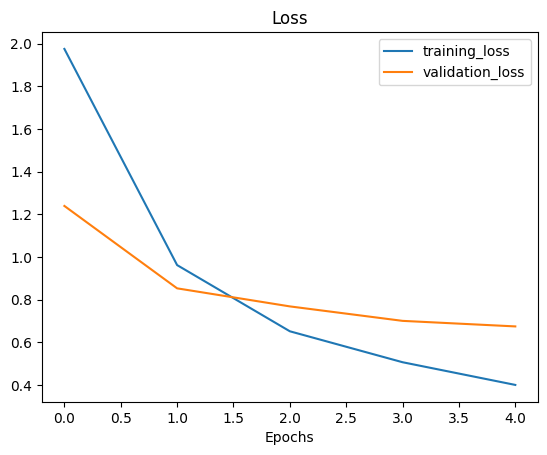

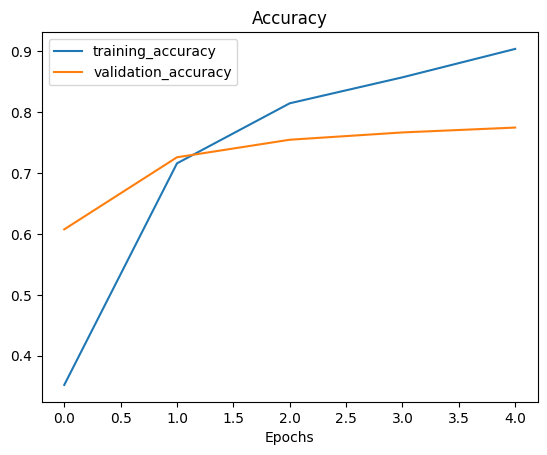

In [ ]:
plot_loss_curves(history_resnet)

### Creating and testing an EfficientNet TensorFlow Hub feature extraction model

In [ ]:
# Create efficientnet feature extractor
efficientnet_model = create_model_from_url(efficientnet_url,
                                           num_classes = train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(tf.keras.optimizers.Adam(),
                           loss = 'categorical_crossentropy',
                           metrics = 'accuracy')

# Fit the model using the callback
history_efficientnet = efficientnet_model.fit(train_data_10_percent,
                                              epochs = 5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback('tensorflow_hub','efficientnet_B0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnet_B0/Y1012-133303
Epoch 1/5
24/24 [==============================] - 20s 460ms/step - loss: 1.7617 - accuracy: 0.5000 - val_loss: 1.2279 - val_accuracy: 0.7500
Epoch 2/5
24/24 [==============================] - 10s 409ms/step - loss: 1.0223 - accuracy: 0.7880 - val_loss: 0.8388 - val_accuracy: 0.8252
Epoch 3/5
24/24 [==============================] - 10s 414ms/step - loss: 0.7378 - accuracy: 0.8347 - val_loss: 0.6827 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 9s 385ms/step - loss: 0.5978 - accuracy: 0.8573 - val_loss: 0.6001 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 11s 488ms/step - loss: 0.5084 - accuracy: 0.8933 - val_loss: 0.5500 - val_accuracy: 0.8616


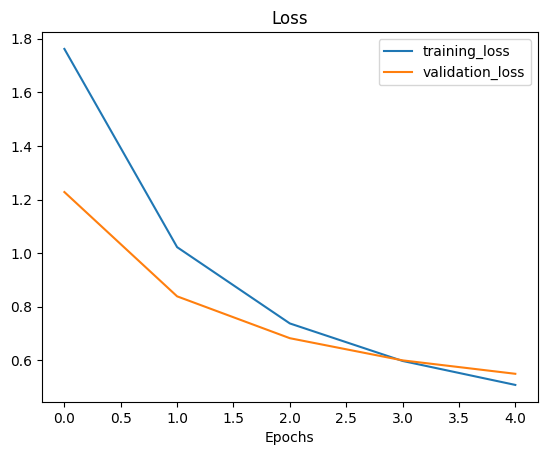

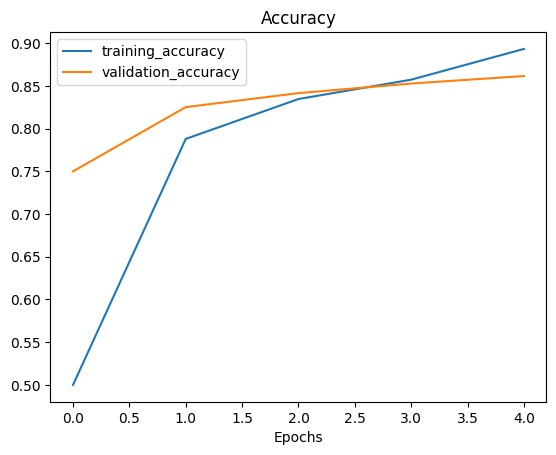

In [ ]:
plot_loss_curves(history_efficientnet)

In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feaure_extraction_layer (K  (None, 1280)              4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


## Different types of transfer learning

* "As is" transfer learning - using an existing model with no changes whatsoever
* Feature extraction - using an existing model and adjust the output layer to fit application
* Fine tuning - use the pre learned patterns and fine-tune the underlying layers

In [ ]:
len(efficientnet_model.layers[0].weights)

309

## Comparing models using TensorBoard

!! TensorBoard is public !!

In [ ]:
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#   --name 'EfficientNetB0 vs. ResNet50V2' \
#   --description 'Comparing two different TH Hub feature extraction model architectures using 10% of the training data' \
#   --one_shot